# Credit Card Fraud Detection

## Data Understanding :

The data set includes credit card transactions made by European cardholders over a period of two days in September 2013. Out of a total of 2,84,807 transactions, 492 were fraudulent. This data set is highly unbalanced, with the positive class (frauds) accounting for 0.172% of the total transactions. The data set has also been modified with principal component analysis (PCA) to maintain confidentiality. Apart from ‘time’ and ‘amount’, all the other features (V1, V2, V3, up to V28) are the principal components obtained using PCA. The feature 'time' contains the seconds elapsed between the first transaction in the data set and the subsequent transactions. The feature 'amount' is the transaction amount. The feature 'class' represents class labelling, and it takes the value of 1 in cases of fraud and 0 in others.

## Table of Contents
1. [Importing dependencies](#p1)
2. [Exploratory data analysis](#p2)
3. [Splitting the data into train & test data](#p3)
4. [Model Building](#p4)
   * [Perform cross validation with RepeatedKFold](#p4-1)
   * [Perform cross validation with StratifiedKFold](#p4-2)
   * [RandomOverSampler with StratifiedKFold Cross Validation](#p4-3)
   * [Oversampling with SMOTE Oversampling](#p4-4)
   * [Oversampling with ADASYN Oversampling](#p4-5)
5. [Hyperparameter Tuning](#p5)
6. [Conclusion](#p6)

## <a name="p1">Importing Dependencies</a>

In [2]:
# Importing the libraries
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score 
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import AdaBoostClassifier

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

## <a name="p2">Exploratory data analysis</a>

In [3]:
# Loading the data
df = pd.read_csv('creditcard.csv')
# df = pd.read_csv('./data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Checking the shape
df.shape

(284807, 31)

In [5]:
# Checking the datatypes and null/non-null distribution
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# Checking distribution of numerical values in the dataset
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
# Checking the class distribution of the target variable
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Class
0    99.827251
1     0.172749
Name: Class, dtype: float64


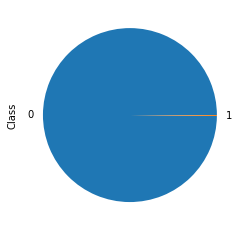

In [8]:
# Checking the class distribution of the target variable in percentage
print((df.groupby('Class')['Class'].count()/df['Class'].count()) *100)
((df.groupby('Class')['Class'].count()/df['Class'].count()) *100).plot.pie()

In [9]:
# Checking the correlation
corr = df.corr()
corr

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.697350e-17,-1.424390e-15,1.755316e-17,6.391162e-17,2.398071e-16,1.991550e-15,-9.490675e-17,2.169581e-16,...,-1.755072e-16,7.477367e-17,9.808705e-16,7.354269e-17,-9.805358e-16,-8.621897e-17,3.208233e-17,9.820892e-16,-0.227709,-0.101347
V2,-0.010593,4.697350e-17,1.000000e+00,2.512175e-16,-1.126388e-16,-2.039868e-16,5.024680e-16,3.966486e-16,-4.413984e-17,-5.728718e-17,...,8.444409e-17,2.500830e-16,1.059562e-16,-8.142354e-18,-4.261894e-17,2.601622e-16,-4.478472e-16,-3.676415e-16,-0.531409,0.091289
V3,-0.419618,-1.424390e-15,2.512175e-16,1.000000e+00,-3.416910e-16,-1.436514e-15,1.431581e-15,2.168574e-15,3.433113e-16,-4.233770e-16,...,-2.971969e-17,4.648259e-16,2.115206e-17,-9.351637e-17,4.771164e-16,6.521501e-16,6.239832e-16,7.726948e-16,-0.210880,-0.192961
V4,-0.105260,1.755316e-17,-1.126388e-16,-3.416910e-16,1.000000e+00,-1.940929e-15,-2.712659e-16,1.556330e-16,5.195643e-16,3.859585e-16,...,-9.976950e-17,2.099922e-16,6.002528e-17,2.229738e-16,5.394585e-16,-6.179751e-16,-6.403423e-17,-5.863664e-17,0.098732,0.133447
V5,0.173072,6.391162e-17,-2.039868e-16,-1.436514e-15,-1.940929e-15,1.000000e+00,7.926364e-16,-4.209851e-16,7.589187e-16,4.205206e-16,...,-1.368701e-16,5.060029e-16,1.637596e-16,-9.286095e-16,5.625102e-16,9.144690e-16,4.465960e-16,-3.299167e-16,-0.386356,-0.094974
V6,-0.063016,2.398071e-16,5.024680e-16,1.431581e-15,-2.712659e-16,7.926364e-16,1.000000e+00,1.429426e-16,-1.707421e-16,1.114447e-16,...,-1.575903e-16,-3.362902e-16,-7.232186e-17,-1.261867e-15,1.081933e-15,-2.378414e-16,-2.623818e-16,4.813155e-16,0.215981,-0.043643
V7,0.084714,1.991550e-15,3.966486e-16,2.168574e-15,1.556330e-16,-4.209851e-16,1.429426e-16,1.000000e+00,-8.691834e-17,7.933251e-16,...,1.938604e-16,-1.058131e-15,2.327911e-16,-2.589727e-17,1.174169e-15,-7.334507e-16,-5.886825e-16,-6.836764e-17,0.397311,-0.187257
V8,-0.036949,-9.490675e-17,-4.413984e-17,3.433113e-16,5.195643e-16,7.589187e-16,-1.707421e-16,-8.691834e-17,1.000000e+00,2.900829e-16,...,-2.412439e-16,5.475559e-16,3.897104e-16,-1.802967e-16,-1.390791e-16,-1.209975e-16,1.733633e-16,-4.484325e-16,-0.103079,0.019875
V9,-0.008660,2.169581e-16,-5.728718e-17,-4.233770e-16,3.859585e-16,4.205206e-16,1.114447e-16,7.933251e-16,2.900829e-16,1.000000e+00,...,4.578389e-17,2.871855e-17,5.929286e-16,-2.346385e-16,1.099645e-15,-1.388725e-15,-2.287414e-16,9.146779e-16,-0.044246,-0.097733


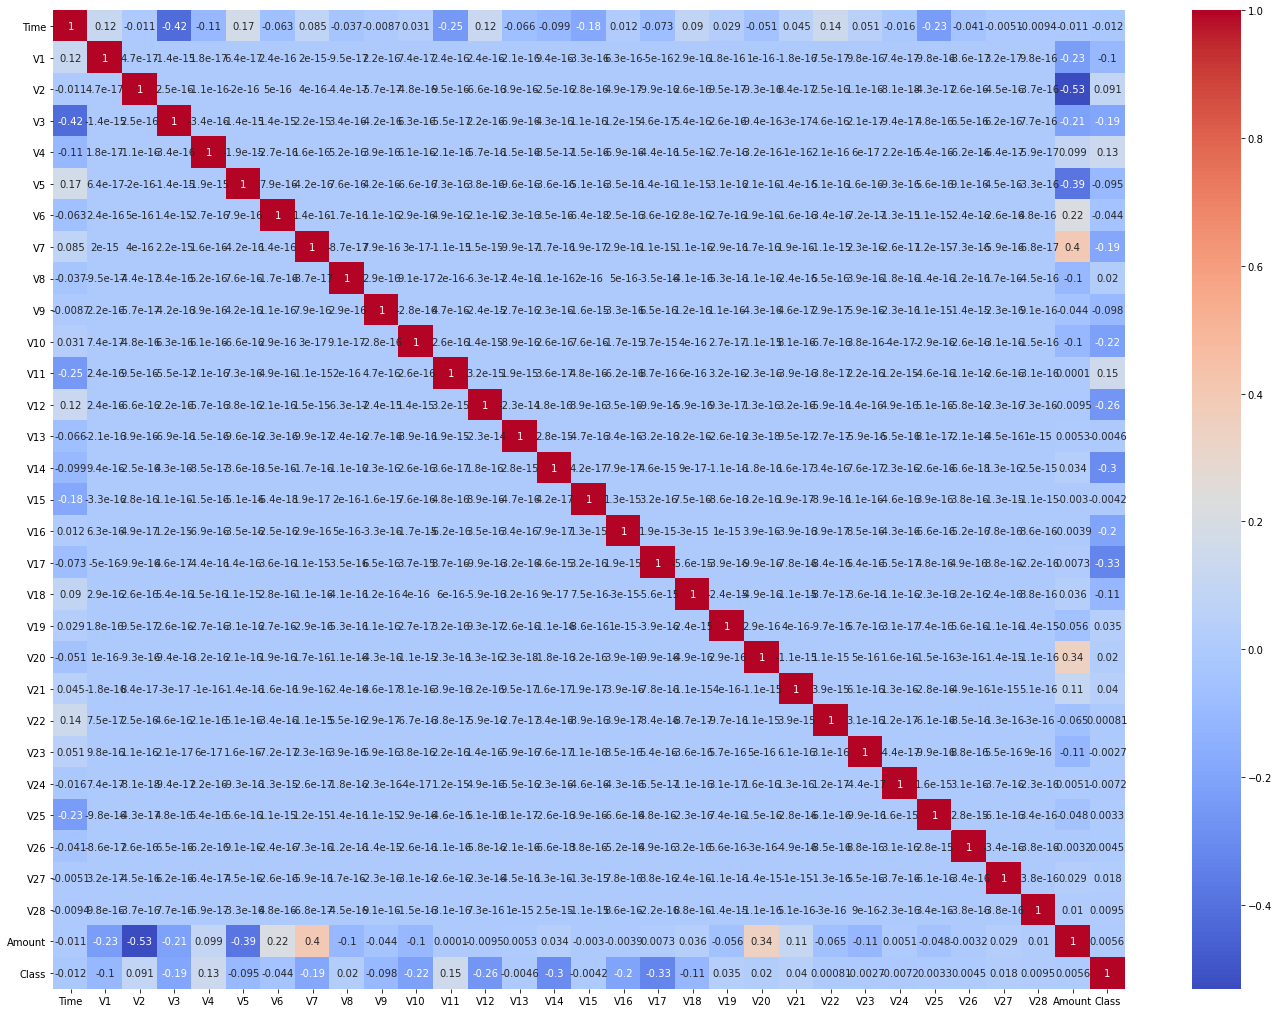

In [10]:
# Checking the correlation in heatmap
plt.figure(figsize=(24,18))

sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.show()

Here we will observe the distribution of our classes

In [11]:
# Checking the % distribution of normal vs fraud
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

print(normal_share)
print(fraud_share)

99.82725143693798
0.1727485630620034


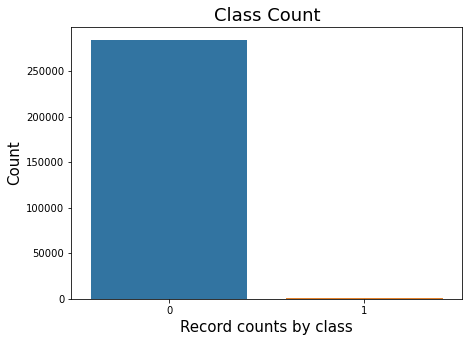

In [12]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
plt.figure(figsize=(7,5))
sns.countplot(df['Class'])
plt.title("Class Count", fontsize=18)
plt.xlabel("Record counts by class", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

In [13]:
# As time is given in relative fashion, we are using pandas.Timedelta which Represents a duration, the difference between two times or dates.
Delta_Time = pd.to_timedelta(df['Time'], unit='s')

#Create derived columns Mins and hours
df['Time_Day'] = (Delta_Time.dt.components.days).astype(int)
df['Time_Hour'] = (Delta_Time.dt.components.hours).astype(int)
df['Time_Min'] = (Delta_Time.dt.components.minutes).astype(int)

In [14]:
# Drop unnecessary columns
# We will drop Time,as we have derived the Day/Hour/Minutes from the time column 
df.drop('Time', axis = 1, inplace= True)
# We will keep only derived column hour, as day/minutes might not be very useful
df.drop(['Time_Day', 'Time_Min'], axis = 1, inplace= True)

## <a name="p3">Splitting the data into train & test data</a>

In [15]:
# Splitting the dataset into X and y
X = df.drop(['Class'], axis=1)
y= df['Class']

In [16]:
# Checking some rows of X
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Time_Hour
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
# Checking some rows of y
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [18]:
# Splitting the dataset using train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.20)

Preserve X_test & y_test to evaluate on the test data once you build the model

In [19]:
# Checking the spread of data post split
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
396
96


Plotting the distribution of a variable

In [20]:
# Accumulating all the column names under one variable
cols = list(X.columns.values)

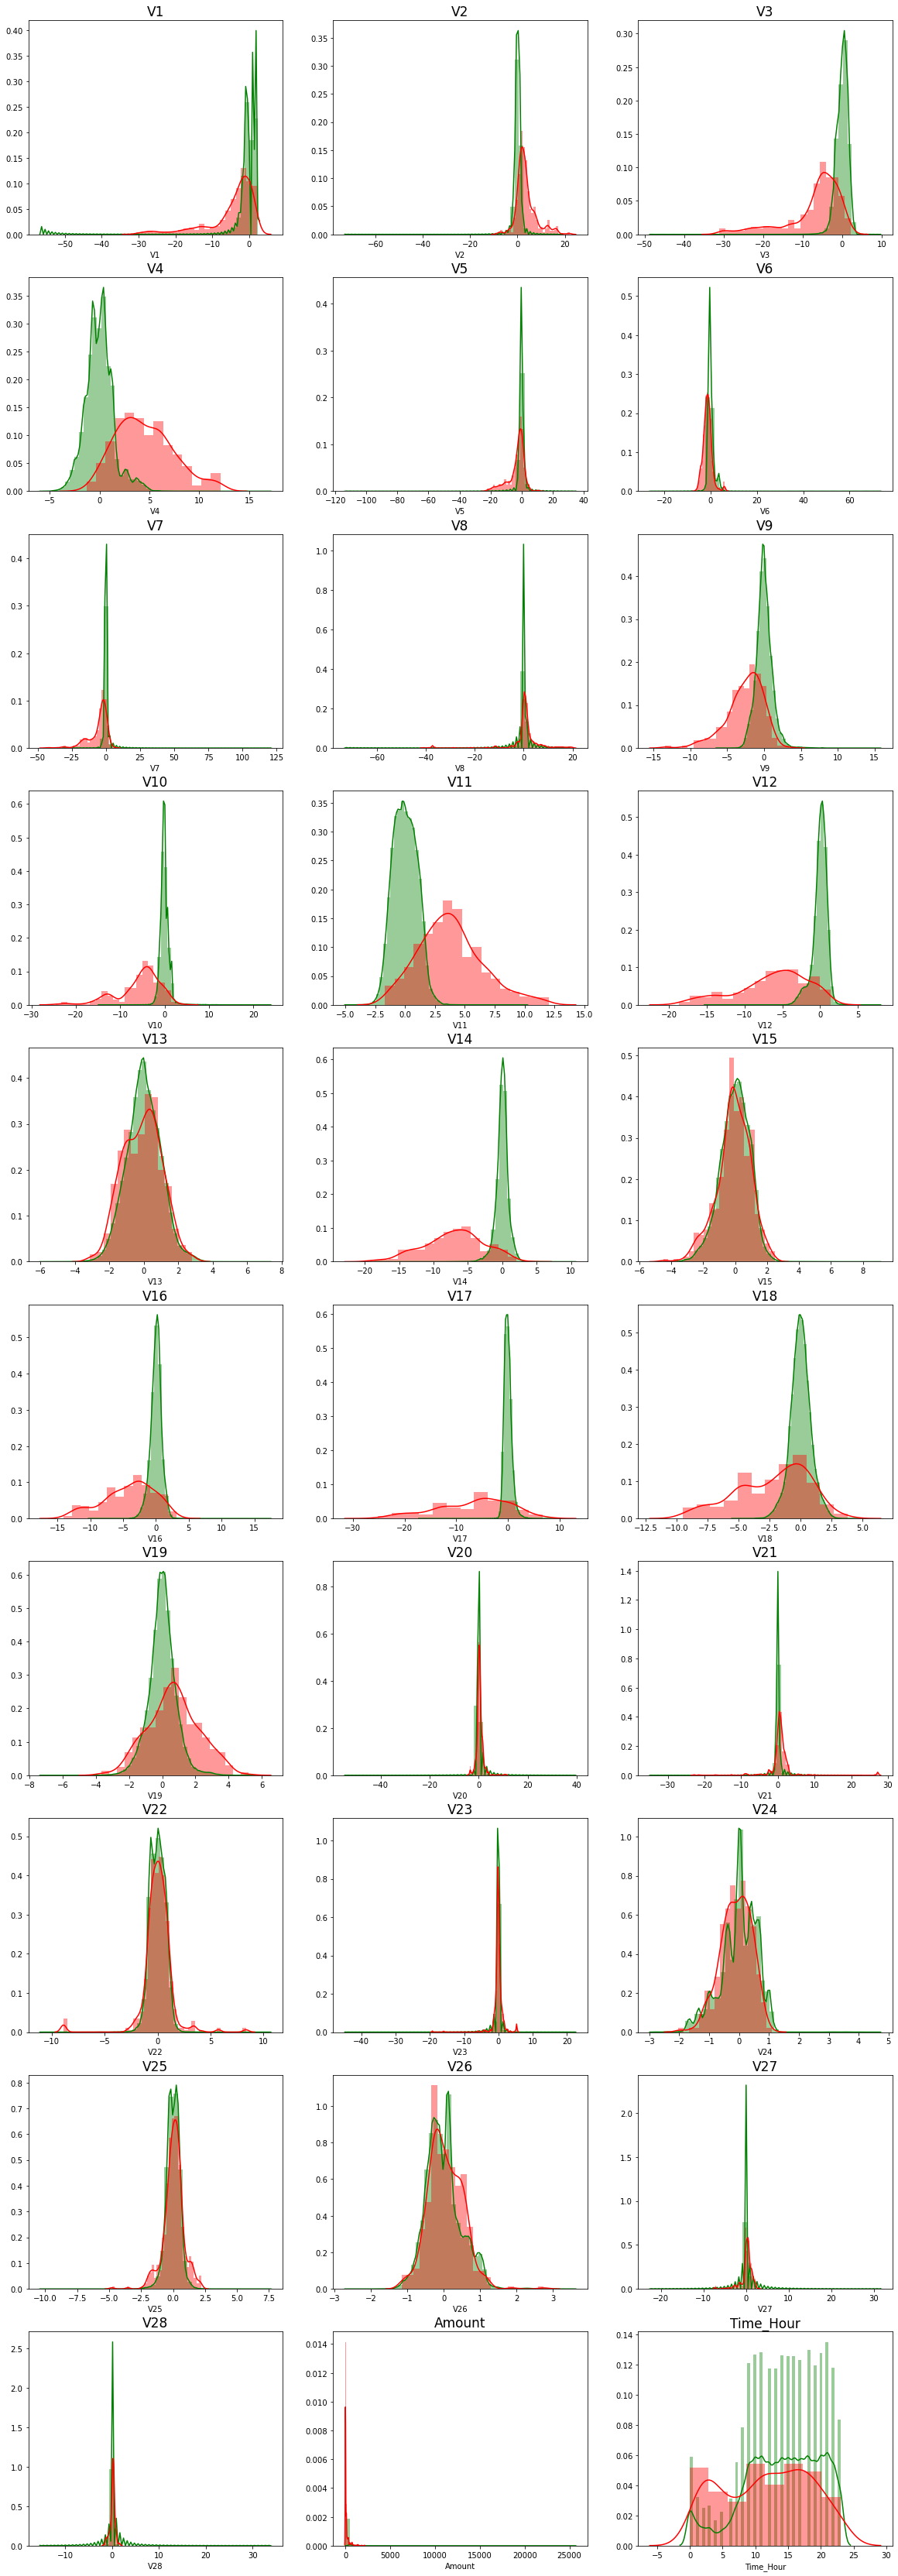

In [32]:
# plot the histogram of a variable from the dataset to see the skewness
normal_records = df.Class == 0
fraud_records = df.Class == 1

plt.figure(figsize=(20, 60))
for n, col in enumerate(cols):
  plt.subplot(10,3,n+1)
  sns.distplot(X[col][normal_records], color='green')
  sns.distplot(X[col][fraud_records], color='red')
  plt.title(col, fontsize=17)
plt.show()

## <a name="p4">Model Building</a>

In [22]:
#Create a dataframe to store results
df_Results = pd.DataFrame(columns=['Methodology','Model','Accuracy','roc_value','threshold'])

In [23]:
# Created a common function to plot confusion matrix
def Plot_confusion_matrix(y_test, pred_test):
  cm = confusion_matrix(y_test, pred_test)
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
  categoryNames = ['Non-Fraudalent','Fraudalent']
  plt.title('Confusion Matrix - Test Data')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  ticks = np.arange(len(categoryNames))
  plt.xticks(ticks, categoryNames, rotation=45)
  plt.yticks(ticks, categoryNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
  plt.show()

In [24]:
# # Created a common function to fit and predict on a Logistic Regression model for both L1 and L2
def buildAndRunLogisticModels(df_Results, Methodology, X_train,y_train, X_test, y_test ):

  # Logistic Regression
  from sklearn import linear_model
  from sklearn.model_selection import KFold

  num_C = list(np.power(10.0, np.arange(-10, 10)))
  cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

  searchCV_l2 = linear_model.LogisticRegressionCV(
          Cs= num_C
          ,penalty='l2'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
      )

  searchCV_l1 = linear_model.LogisticRegressionCV(
          Cs=num_C
          ,penalty='l1'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='liblinear'
          ,tol=10
      )

  searchCV_l1.fit(X_train, y_train)
  searchCV_l2.fit(X_train, y_train)
  print ('Max auc_roc for l1:', searchCV_l1.scores_[1].mean(axis=0).max())
  print ('Max auc_roc for l2:', searchCV_l2.scores_[1].mean(axis=0).max())

  print("Parameters for l1 regularisations")
  print(searchCV_l1.coef_)
  print(searchCV_l1.intercept_) 
  print(searchCV_l1.scores_)

  print("Parameters for l2 regularisations")
  print(searchCV_l2.coef_)
  print(searchCV_l2.intercept_) 
  print(searchCV_l2.scores_)  


  #find predicted vallues
  y_pred_l1 = searchCV_l1.predict(X_test)
  y_pred_l2 = searchCV_l2.predict(X_test)
  

  #Find predicted probabilities
  y_pred_probs_l1 = searchCV_l1.predict_proba(X_test)[:,1] 
  y_pred_probs_l2 = searchCV_l2.predict_proba(X_test)[:,1] 

  # Accuaracy of L2/L1 models
  Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)
  Accuracy_l1 = metrics.accuracy_score(y_pred=y_pred_l1, y_true=y_test)

  print("Accuarcy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2))
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred_l2)
  print("classification Report")
  print(classification_report(y_test, y_pred_l2))
    
  print("Accuarcy of Logistic model with l1 regularisation : {0}".format(Accuracy_l1))
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred_l1)
  print("classification Report")
  print(classification_report(y_test, y_pred_l1))

  l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
  print("l2 roc_value: {0}" .format(l2_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l2 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'Logistic Regression with L2 Regularisation','Accuracy': Accuracy_l2,'roc_value': l2_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  l1_roc_value = roc_auc_score(y_test, y_pred_probs_l1)
  print("l1 roc_value: {0}" .format(l1_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l1)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l1 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'Logistic Regression with L1 Regularisation','Accuracy': Accuracy_l1,'roc_value': l1_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)
  return df_Results

In [25]:
# Created a common function to fit and predict on a KNN model
def buildAndRunKNNModels(df_Results,Methodology, X_train,y_train, X_test, y_test ):

  #create KNN model and fit the model with train dataset
  knn = KNeighborsClassifier(n_neighbors = 5,n_jobs=16)
  knn.fit(X_train,y_train)
  score = knn.score(X_test,y_test)
  print("model score")
  print(score)
  
  #Accuracy
  y_pred = knn.predict(X_test)
  KNN_Accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred)
  print("classification Report")
  print(classification_report(y_test, y_pred))


  knn_probs = knn.predict_proba(X_test)[:, 1]

  # Calculate roc auc
  knn_roc_value = roc_auc_score(y_test, knn_probs)
  print("KNN roc_value: {0}" .format(knn_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("KNN threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'KNN','Accuracy': score,'roc_value': knn_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

In [26]:
# Created a common function to fit and predict on a Tree models for both gini and entropy criteria
def buildAndRunTreeModels(df_Results, Methodology, X_train,y_train, X_test, y_test ):
  #Evaluate Decision Tree model with 'gini' & 'entropy'
  criteria = ['gini', 'entropy'] 
  scores = {} 
    
  for c in criteria: 
      dt = DecisionTreeClassifier(criterion = c, random_state=42) 
      dt.fit(X_train, y_train) 
      y_pred = dt.predict(X_test)
      test_score = dt.score(X_test, y_test) 
      tree_preds = dt.predict_proba(X_test)[:, 1]
      tree_roc_value = roc_auc_score(y_test, tree_preds)
      scores = test_score 
      print(c + " score: {0}" .format(test_score))
      print("Confusion Matrix")
      Plot_confusion_matrix(y_test, y_pred)
      print("classification Report")
      print(classification_report(y_test, y_pred))
      print(c + " tree_roc_value: {0}" .format(tree_roc_value))
      fpr, tpr, thresholds = metrics.roc_curve(y_test, tree_preds)
      threshold = thresholds[np.argmax(tpr-fpr)]
      print("Tree threshold: {0}".format(threshold))
      roc_auc = metrics.auc(fpr, tpr)
      print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
      plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
      plt.legend(loc=4)
      plt.show()
  
      df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'Tree Model with {0} criteria'.format(c),'Accuracy': test_score,'roc_value': tree_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

In [27]:
# Created a common function to fit and predict on a Random Forest model
def buildAndRunRandomForestModels(df_Results, Methodology, X_train,y_train, X_test, y_test ):
  #Evaluate Random Forest model

  # Create the model with 100 trees
  RF_model = RandomForestClassifier(n_estimators=100, 
                                bootstrap = True,
                                max_features = 'sqrt', random_state=42)
  # Fit on training data
  RF_model.fit(X_train, y_train)
  RF_test_score = RF_model.score(X_test, y_test)
  RF_model.predict(X_test)

  print('Model Accuracy: {0}'.format(RF_test_score))


  # Actual class predictions
  rf_predictions = RF_model.predict(X_test)

  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, rf_predictions)
  print("classification Report")
  print(classification_report(y_test, rf_predictions))

  # Probabilities for each class
  rf_probs = RF_model.predict_proba(X_test)[:, 1]

  # Calculate roc auc
  roc_value = roc_auc_score(y_test, rf_probs)

  print("Random Forest roc_value: {0}" .format(roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("Random Forest threshold: {0}".format(threshold))
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'Random Forest','Accuracy': RF_test_score,'roc_value': roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

In [28]:
# Created a common function to fit and predict on a XGBoost model
def buildAndRunXGBoostModels(df_Results, Methodology,X_train,y_train, X_test, y_test ):
  #Evaluate XGboost model
  XGBmodel = XGBClassifier(random_state=42)
  XGBmodel.fit(X_train, y_train)
  y_pred = XGBmodel.predict(X_test)

  XGB_test_score = XGBmodel.score(X_test, y_test)
  print('Model Accuracy: {0}'.format(XGB_test_score))

  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred)
  print("classification Report")
  print(classification_report(y_test, y_pred))
  # Probabilities for each class
  XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

  # Calculate roc auc
  XGB_roc_value = roc_auc_score(y_test, XGB_probs)

  print("XGboost roc_value: {0}" .format(XGB_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("XGBoost threshold: {0}".format(threshold))
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'XGBoost','Accuracy': XGB_test_score,'roc_value': XGB_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results


In [29]:
# Created a common function to fit and predict on a SVM model
def buildAndRunSVMModels(df_Results, Methodology, X_train,y_train, X_test, y_test ):
  #Evaluate SVM model with sigmoid kernel  model
  from sklearn.svm import SVC
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import roc_auc_score

  clf = SVC(kernel='sigmoid', random_state=42)
  clf.fit(X_train,y_train)
  y_pred_SVM = clf.predict(X_test)
  SVM_Score = accuracy_score(y_test,y_pred_SVM)
  print("accuracy_score : {0}".format(SVM_Score))
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred_SVM)
  print("classification Report")
  print(classification_report(y_test, y_pred_SVM))

  # Run classifier
  classifier = SVC(kernel='sigmoid' , probability=True)
  svm_probs = classifier.fit(X_train, y_train).predict_proba(X_test)[:, 1]

  # Calculate roc auc
  roc_value = roc_auc_score(y_test, svm_probs)
  
  print("SVM roc_value: {0}" .format(roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, svm_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("SVM threshold: {0}".format(threshold))
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'SVM','Accuracy': SVM_Score,'roc_value': roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

- Build different models on the imbalanced dataset and see the result

## <a name="p4-1">Perform cross validation with RepeatedKFold</a>

In [30]:
#Lets perfrom RepeatedKFold and check the results
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in rkf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [     5      6     12 ... 284791 284796 284803]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [    10     11     15 ... 284785 284793 284795]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [     4     18     24 ... 284788 284794 284800]
TRAIN: [     0      1      2 ... 284803 284805 284806] TEST: [     3      7     13 ... 284799 284801 284804]
TRAIN: [     3      4      5 ... 284801 284803 284804] TEST: [     0      1      2 ... 284802 284805 284806]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [     7      8      9 ... 284795 284797 284802]
TRAIN: [     0      1      2 ... 284802 284803 284804] TEST: [     4      6     15 ... 284796 284805 284806]
TRAIN: [     0      1      3 ... 284804 284805 284806] TEST: [     2     10     11 ... 284793 284801 284803]
TRAIN: [     2      3      4 ... 284804 284805 284806] TEST: [     0      1     17 ... 284782 284790 284794]
TRAIN: [     0     

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l1: 0.9757741295537155
Max auc_roc for l2: 0.9865741449266722
Parameters for l1 regularisations
[[-0.05664497 -0.12515701 -0.18527504  0.0659936  -0.26440918  0.09351725
   0.1218119  -0.03176011 -0.1478769  -0.14916947 -0.02962538  0.00313734
  -0.13632793 -0.22700063  0.01235601 -0.12010628 -0.23319794  0.03095384
   0.01223133  0.24200061  0.09337734 -0.02531852  0.00942889 -0.01410184
  -0.02038237  0.00027867 -0.06441265 -0.00383413 -0.006582   -0.1164491 ]]
[-2.09682918]
{1: array([[0.5       , 0.5       , 0.5       , 0.5       , 0.60309428,
        0.6149433 , 0.62232097, 0.92291065, 0.93588395, 0.93713444,
        0.92093358, 0.92534087, 0.93549294, 0.93159234, 0.92892502,
        0.92978354, 0.92453112, 0.93841169, 0.9420121 , 0.95249686],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.53975808,
        0.53338235, 0.53864862, 0.87791416, 0.8932588 , 0.91288678,
        0.88595075, 0.88708285, 0.91274

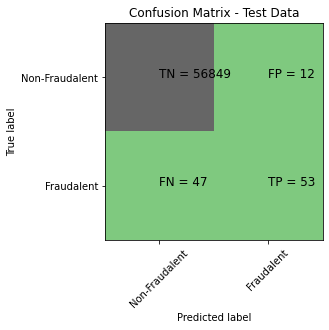

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.82      0.53      0.64       100

    accuracy                           1.00     56961
   macro avg       0.91      0.76      0.82     56961
weighted avg       1.00      1.00      1.00     56961

Accuarcy of Logistic model with l1 regularisation : 0.9989290918347641
Confusion Matrix


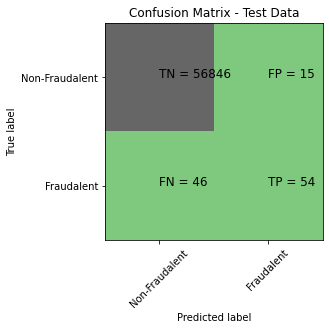

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.78      0.54      0.64       100

    accuracy                           1.00     56961
   macro avg       0.89      0.77      0.82     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9690107455021895
l2 threshold: 0.0014225337256554363
ROC for the test dataset 96.9%


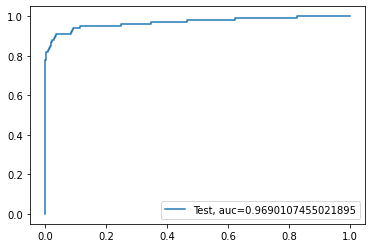

l1 roc_value: 0.869288616098908
l1 threshold: 0.0472303427873661
ROC for the test dataset 86.9%


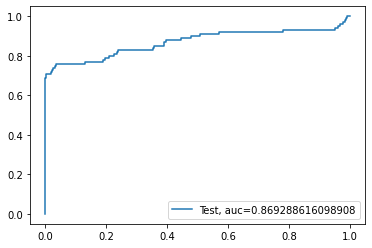

Time Taken by Model: --- 344.7267997264862 seconds ---
------------------------------------------------------------
KNN Model
model score
0.9992626533944278
Confusion Matrix


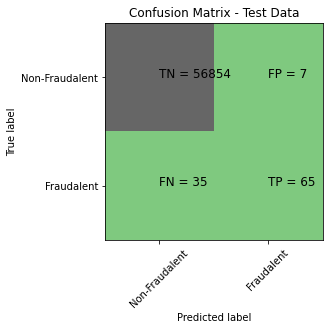

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.90      0.65      0.76       100

    accuracy                           1.00     56961
   macro avg       0.95      0.82      0.88     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc_value: 0.8648265946782504
KNN threshold: 0.2
ROC for the test dataset 86.5%


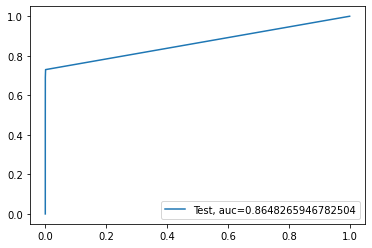

Time Taken by Model: --- 1256.2385637760162 seconds ---
------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9992450975228665
Confusion Matrix


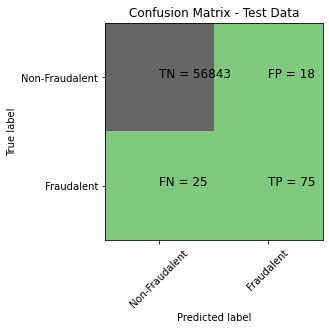

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.81      0.75      0.78       100

    accuracy                           1.00     56961
   macro avg       0.90      0.87      0.89     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8748417192803503
Tree threshold: 1.0
ROC for the test dataset 87.5%


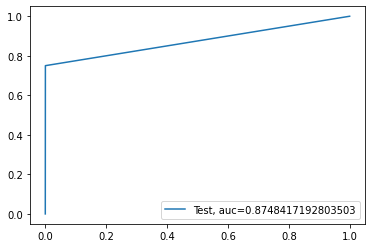

entropy score: 0.9990870946788153
Confusion Matrix


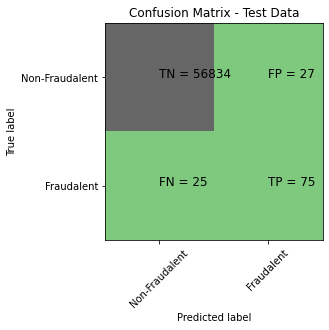

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.74      0.75      0.74       100

    accuracy                           1.00     56961
   macro avg       0.87      0.87      0.87     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8747625789205256
Tree threshold: 1.0
ROC for the test dataset 87.5%


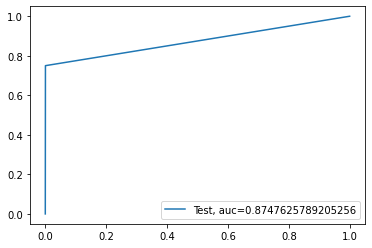

Time Taken by Model: --- 37.0897114276886 seconds ---
------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.999490879724724
Confusion Matrix


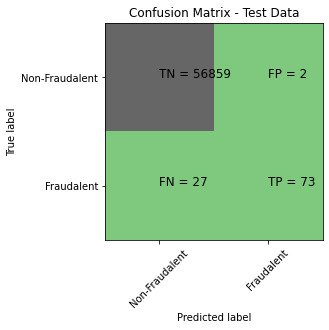

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.97      0.73      0.83       100

    accuracy                           1.00     56961
   macro avg       0.99      0.86      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9328157260688346
Random Forest threshold: 0.01
ROC for the test dataset 93.3%


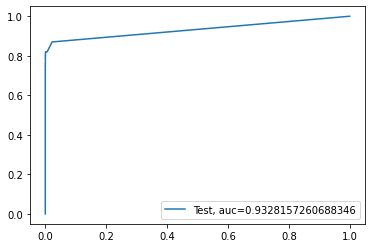

Time Taken by Model: --- 214.1870892047882 seconds ---
------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


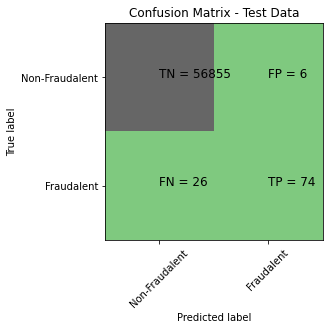

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.93      0.74      0.82       100

    accuracy                           1.00     56961
   macro avg       0.96      0.87      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9701069274194967
XGBoost threshold: 0.0014467865694314241
ROC for the test dataset 97.0%


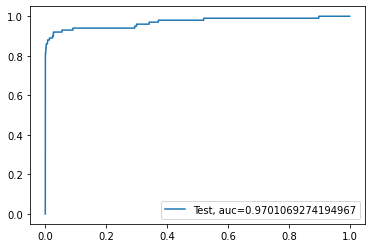

Time Taken by Model: --- 53.274091482162476 seconds ---
------------------------------------------------------------
SVM Model with Sigmoid Kernel
accuracy_score : 0.9980864099998245
Confusion Matrix


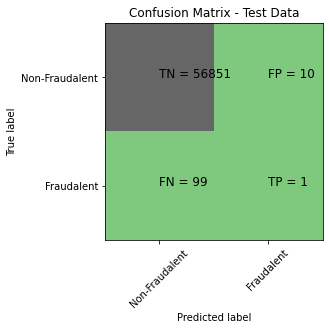

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.09      0.01      0.02       100

    accuracy                           1.00     56961
   macro avg       0.54      0.50      0.51     56961
weighted avg       1.00      1.00      1.00     56961

SVM roc_value: 0.42160602170204536
SVM threshold: 0.002741365025150363
ROC for the test dataset 42.2%


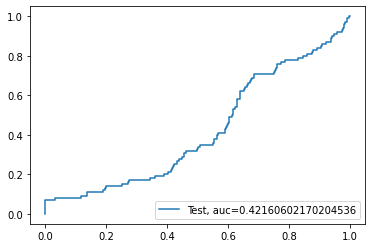

Time Taken by Model: --- 633.070867061615 seconds ---


In [31]:
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results,"RepeatedKFold Cross Validation", X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

#Run KNN Model
print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

#Run XGBoost Modela
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

#Run SVM Model with Sigmoid Kernel
print("SVM Model with Sigmoid Kernel")
start_time = time.time()
df_Results = buildAndRunSVMModels(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

In [32]:
# Checking the df_result dataframe which contains consolidated results of all the runs
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998964,0.969011,0.001423
1,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998929,0.869289,0.047230
2,RepeatedKFold Cross Validation,KNN,0.999263,0.864827,0.200000
3,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999245,0.874842,1.000000
4,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999087,0.874763,1.000000
5,RepeatedKFold Cross Validation,Random Forest,0.999491,0.932816,0.010000
6,RepeatedKFold Cross Validation,XGBoost,0.999438,0.970107,0.001447
7,RepeatedKFold Cross Validation,SVM,0.998086,0.421606,0.002741


### Results for cross validation with RepeatedKFold:
Looking at Accuracy and ROC value we have "Logistic Regression with L2 Regularisation" which has provided best results for cross validation with RepeatedKFold technique

## <a name="p4-2">Perform cross validation with StratifiedKFold</a>

In [33]:
#Lets perfrom StratifiedKFold and check the results
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_SKF_cv, X_test_SKF_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_SKF_cv, y_test_SKF_cv = y.iloc[train_index], y.iloc[test_index]

TRAIN: [ 30473  30496  31002 ... 284804 284805 284806] TEST: [    0     1     2 ... 57017 57018 57019]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 30473  30496  31002 ... 113964 113965 113966]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 81609  82400  83053 ... 170946 170947 170948]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [150654 150660 150661 ... 227866 227867 227868]
TRAIN: [     0      1      2 ... 227866 227867 227868] TEST: [212516 212644 213092 ... 284804 284805 284806]


Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l1: 0.9652106893977332
Max auc_roc for l2: 0.9825816914072499
Parameters for l1 regularisations
[[-0.03660539 -0.1358827  -0.20474594  0.04333662 -0.24034598  0.08416903
   0.12654905 -0.04815306 -0.14258132 -0.1384162  -0.11668372  0.05505155
  -0.15637116 -0.24216184 -0.03137093 -0.09904364 -0.23133976  0.05582481
   0.02122044  0.20503748  0.09013502  0.00148754 -0.03796378 -0.00392139
  -0.14797782 -0.00701001 -0.06594801 -0.00660368 -0.00656465 -0.12981985]]
[-2.0409044]
{1: array([[0.5       , 0.5       , 0.5       , 0.5       , 0.48341269,
        0.44979055, 0.48500892, 0.78098262, 0.9497821 , 0.94525947,
        0.91827811, 0.91446679, 0.94989144, 0.94933682, 0.94178407,
        0.94900653, 0.92481293, 0.94421561, 0.9164553 , 0.97793244],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.54612019,
        0.57709187, 0.60597219, 0.84651057, 0.93343227, 0.93465714,
        0.92629828, 0.92557122, 0.944815

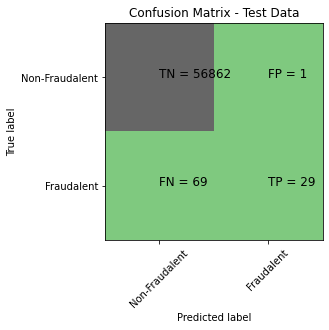

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.97      0.30      0.45        98

    accuracy                           1.00     56961
   macro avg       0.98      0.65      0.73     56961
weighted avg       1.00      1.00      1.00     56961

Accuarcy of Logistic model with l1 regularisation : 0.9987535331191517
Confusion Matrix


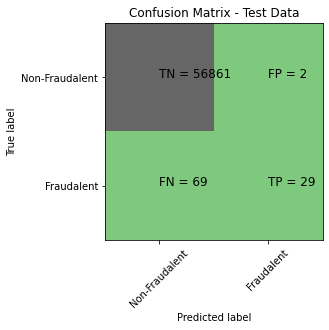

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.30      0.45        98

    accuracy                           1.00     56961
   macro avg       0.97      0.65      0.72     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9833290683981945
l2 threshold: 0.0015722938315703933
ROC for the test dataset 98.3%


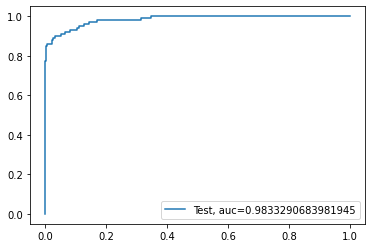

l1 roc_value: 0.8890758561483437
l1 threshold: 0.021087492766199985
ROC for the test dataset 88.9%


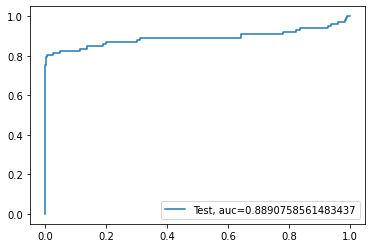

Time Taken by Model: --- 348.1904556751251 seconds ---
------------------------------------------------------------
KNN Model
model score
0.9991924299081828
Confusion Matrix


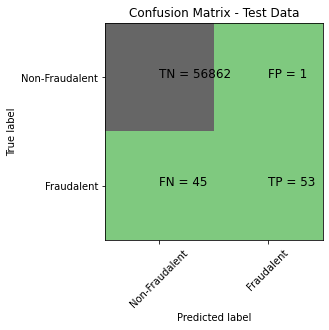

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.98      0.54      0.70        98

    accuracy                           1.00     56961
   macro avg       0.99      0.77      0.85     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc_value: 0.8057457828285457
KNN threshold: 0.2
ROC for the test dataset 80.6%


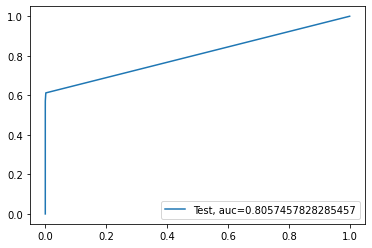

Time Taken by Model: --- 1204.463027715683 seconds ---
------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.998841312476958
Confusion Matrix


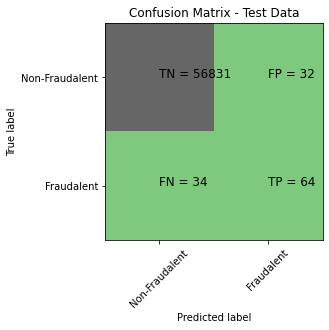

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.67      0.65      0.66        98

    accuracy                           1.00     56961
   macro avg       0.83      0.83      0.83     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8262492341959029
Tree threshold: 1.0
ROC for the test dataset 82.6%


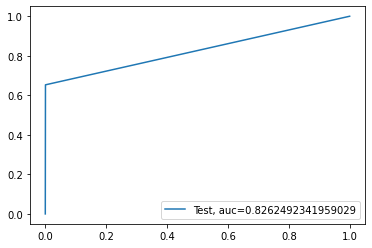

entropy score: 0.9990168711925703
Confusion Matrix


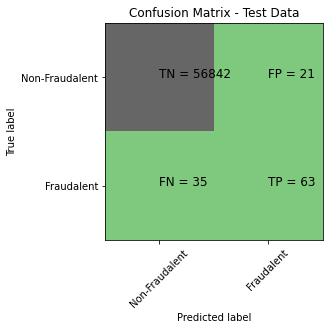

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.75      0.64      0.69        98

    accuracy                           1.00     56961
   macro avg       0.87      0.82      0.85     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8212439170839185
Tree threshold: 1.0
ROC for the test dataset 82.1%


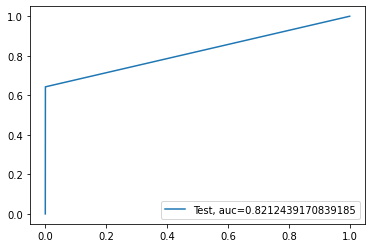

Time Taken by Model: --- 35.2624135017395 seconds ---
------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


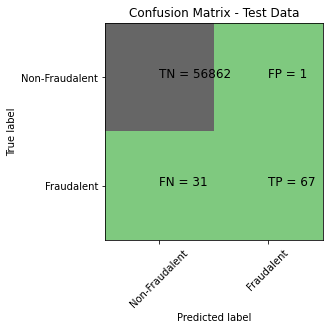

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.68      0.81        98

    accuracy                           1.00     56961
   macro avg       0.99      0.84      0.90     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9464721329855826
Random Forest threshold: 0.01
ROC for the test dataset 94.6%


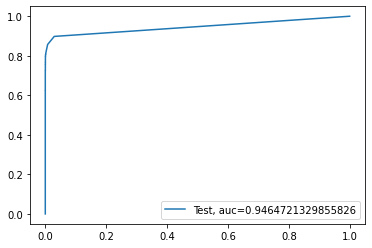

Time Taken by Model: --- 212.89058995246887 seconds ---
------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9993855444953564
Confusion Matrix


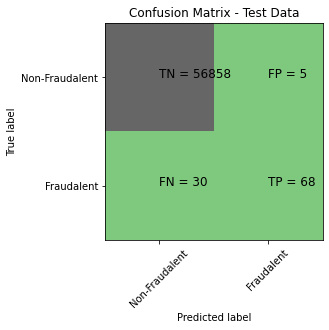

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.69      0.80        98

    accuracy                           1.00     56961
   macro avg       0.97      0.85      0.90     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9781480694558744
XGBoost threshold: 0.002443221863359213
ROC for the test dataset 97.8%


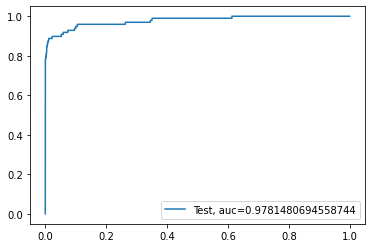

Time Taken by Model: --- 53.351813554763794 seconds ---
------------------------------------------------------------
SVM Model with Sigmoid Kernel
accuracy_score : 0.9982795245869981
Confusion Matrix


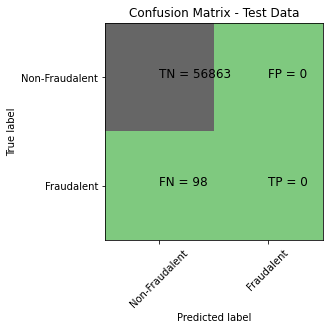

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

SVM roc_value: 0.5982296511450543
SVM threshold: 0.0016944278710473513
ROC for the test dataset 59.8%


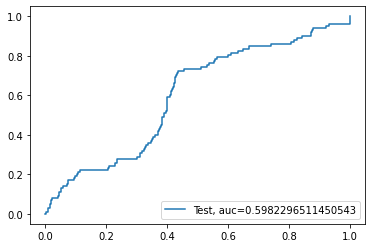

Time Taken by Model: --- 1369.9990856647491 seconds ---


In [34]:
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results,"StratifiedKFold Cross Validation", X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

#Run KNN Model
print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

#Run XGBoost Modela
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

#Run SVM Model with Sigmoid Kernel
print("SVM Model with Sigmoid Kernel")
start_time = time.time()
df_Results = buildAndRunSVMModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

In [35]:
# Checking the df_result dataframe which contains consolidated results of all the runs
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998964,0.969011,0.001423
1,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998929,0.869289,0.047230
2,RepeatedKFold Cross Validation,KNN,0.999263,0.864827,0.200000
3,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999245,0.874842,1.000000
4,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999087,0.874763,1.000000
5,RepeatedKFold Cross Validation,Random Forest,0.999491,0.932816,0.010000
6,RepeatedKFold Cross Validation,XGBoost,0.999438,0.970107,0.001447
7,RepeatedKFold Cross Validation,SVM,0.998086,0.421606,0.002741
8,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998771,0.983329,0.001572
9,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998754,0.889076,0.021087


### Results for cross validation with StratifiedKFold:
Looking at the ROC value we have Logistic Regression with L2 Regularisation has provided best results for cross validation with StratifiedKFold technique

## Conclusion : 
- As the results show Logistic Regression with L2 Regularisation for StratifiedKFold cross validation provided best results



#### Proceed with the model which shows the best result 
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [36]:
# Logistic Regression
from sklearn import linear_model #import the package
from sklearn.model_selection import KFold

num_C = list(np.power(10.0, np.arange(-10, 10)))
cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

clf = linear_model.LogisticRegressionCV(
          Cs= num_C
          ,penalty='l2'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
      )

clf.fit(X_train_SKF_cv, y_train_SKF_cv)
print ('Max auc_roc for l2:', clf.scores_[1].mean(axis=0).max())


print("Parameters for l2 regularisations")
print(clf.coef_)
print(clf.intercept_) 
print(clf.scores_) 


#find predicted vallues
y_pred_l2 = clf.predict(X_test)


#Find predicted probabilities
y_pred_probs_l2 = clf.predict_proba(X_test)[:,1] 


# Accuaracy of L2/L1 models
Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)


print("Accuarcy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2))


from sklearn.metrics import roc_auc_score
l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
print("l2 roc_value: {0}" .format(l2_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
threshold = thresholds[np.argmax(tpr-fpr)]
print("l2 threshold: {0}".format(threshold))

Max auc_roc for l2: 0.9865741449266722
Parameters for l2 regularisations
[[ 8.81955672e-03  4.12852966e-02 -8.73597273e-02  2.31593930e-01
   8.23465655e-02 -5.16810590e-02 -4.00236018e-02 -1.21892419e-01
  -8.37934902e-02 -1.88393098e-01  1.47808325e-01 -2.13768201e-01
  -3.73003674e-02 -3.80938168e-01 -4.79315972e-03 -1.05538339e-01
  -9.33039347e-02 -4.43804397e-03  1.14866801e-02 -7.35149625e-03
   4.44308093e-02  3.04505742e-02 -8.51460452e-03 -1.50983112e-02
  -6.56644541e-03  5.37855175e-03 -8.33077400e-03 -6.17909130e-05
   3.22049047e-04  9.96568363e-03]]
[-7.6233989]
{1: array([[0.53980902, 0.54182146, 0.56634264, 0.74371077, 0.91438765,
        0.95390987, 0.96803901, 0.97816813, 0.96897688, 0.95944719,
        0.95944719, 0.95485347, 0.95485347, 0.95485347, 0.95485347,
        0.95485347, 0.95485347, 0.95485347, 0.95485347, 0.95485347],
       [0.58448142, 0.58599444, 0.60685041, 0.76199495, 0.92335672,
        0.94993447, 0.96479963, 0.96984747, 0.97499254, 0.9766534 ,
   

In [37]:
# Checking for the coefficient values
clf.coef_

array([[ 8.81955672e-03,  4.12852966e-02, -8.73597273e-02,
         2.31593930e-01,  8.23465655e-02, -5.16810590e-02,
        -4.00236018e-02, -1.21892419e-01, -8.37934902e-02,
        -1.88393098e-01,  1.47808325e-01, -2.13768201e-01,
        -3.73003674e-02, -3.80938168e-01, -4.79315972e-03,
        -1.05538339e-01, -9.33039347e-02, -4.43804397e-03,
         1.14866801e-02, -7.35149625e-03,  4.44308093e-02,
         3.04505742e-02, -8.51460452e-03, -1.50983112e-02,
        -6.56644541e-03,  5.37855175e-03, -8.33077400e-03,
        -6.17909130e-05,  3.22049047e-04,  9.96568363e-03]])

In [38]:
# Creating a dataframe with the coefficient values
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
coefficients.columns = ['Feature','Importance Coefficient']

In [39]:
coefficients

,Feature,Importance Coefficient
0,V1,0.008820
1,V2,0.041285
2,V3,-0.087360
3,V4,0.231594
4,V5,0.082347
5,V6,-0.051681
6,V7,-0.040024
7,V8,-0.121892
8,V9,-0.083793
9,V10,-0.188393


### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

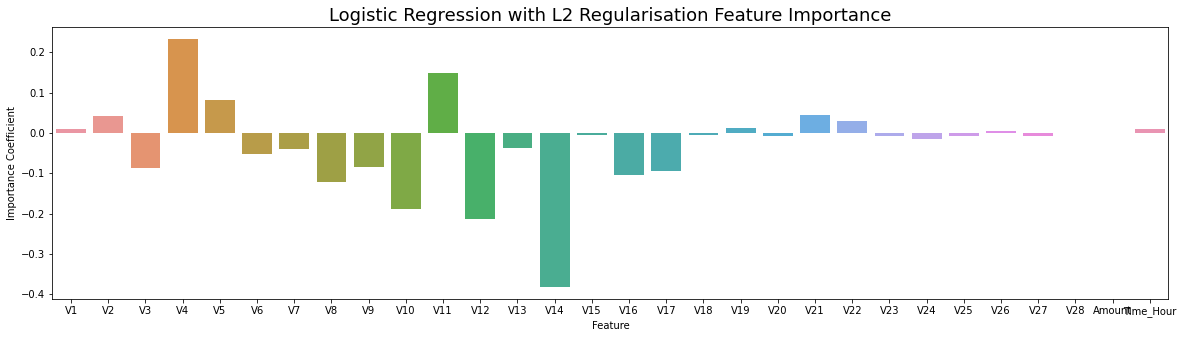

In [40]:
# Plotting the coefficient values
plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Importance Coefficient', data=coefficients)
plt.title("Logistic Regression with L2 Regularisation Feature Importance", fontsize=18)

plt.show()

Hence it implies that V4, v5,V11 has + ve importance whereas V10, V12, V14 seems to have -ve impact on the predictaions

# Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## <a name="p4-3">Oversampling with RandomOverSampler with StratifiedKFold Cross Validation</a>

- We will use Random Oversampling method to handle the class imbalance

In [42]:
# Creating the dataset with RandomOverSampler and StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  
    ROS = RandomOverSampler(sampling_strategy=0.5)
    X_over, y_over= ROS.fit_resample(X_train, y_train)
  
X_over = pd.DataFrame(data=X_over, columns=cols)

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l1: 0.5
Max auc_roc for l2: 0.9865694580981696
Parameters for l1 regularisations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5

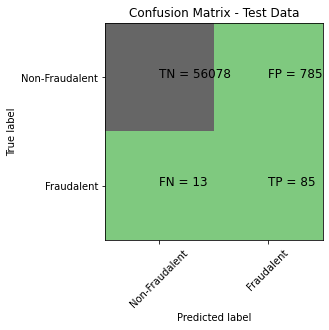

classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.10      0.87      0.18        98

    accuracy                           0.99     56961
   macro avg       0.55      0.93      0.58     56961
weighted avg       1.00      0.99      0.99     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


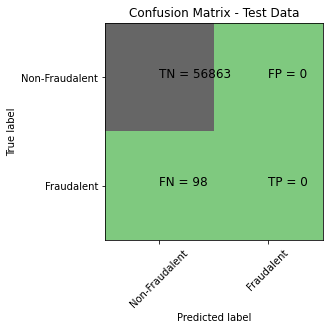

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9807634676542653
l2 threshold: 0.43450954007638304
ROC for the test dataset 98.1%


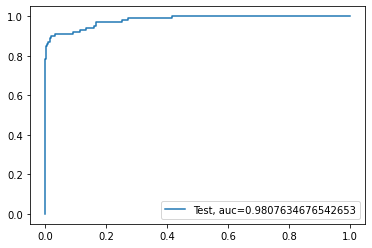

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


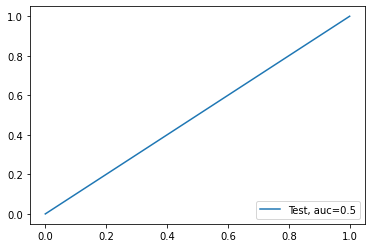

Time Taken by Model: --- 438.3937211036682 seconds ---
------------------------------------------------------------
KNN Model
model score
0.9980688541282632
Confusion Matrix


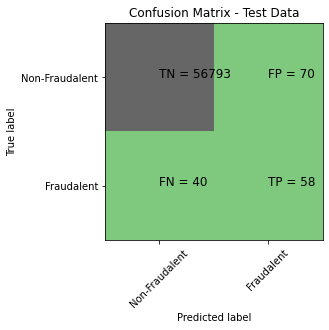

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.45      0.59      0.51        98

    accuracy                           1.00     56961
   macro avg       0.73      0.80      0.76     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc_value: 0.805604465728046
KNN threshold: 0.2
ROC for the test dataset 80.6%


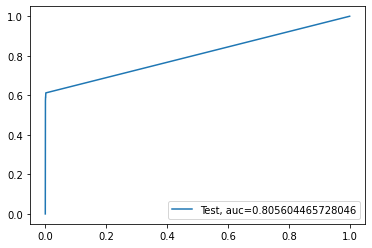

Time Taken by Model: --- 2119.8244297504425 seconds ---
------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9989466477063254
Confusion Matrix


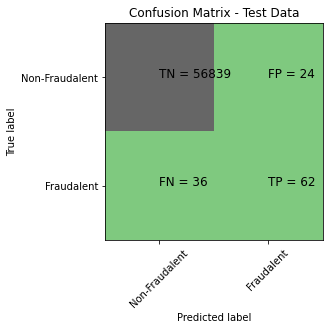

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.72      0.63      0.67        98

    accuracy                           1.00     56961
   macro avg       0.86      0.82      0.84     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8161154970754987
Tree threshold: 1.0
ROC for the test dataset 81.6%


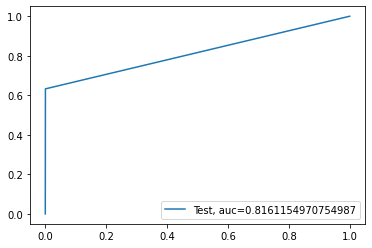

entropy score: 0.9992626533944278
Confusion Matrix


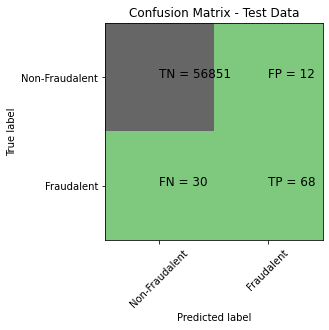

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.85      0.69      0.76        98

    accuracy                           1.00     56961
   macro avg       0.92      0.85      0.88     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8468332587418309
Tree threshold: 1.0
ROC for the test dataset 84.7%


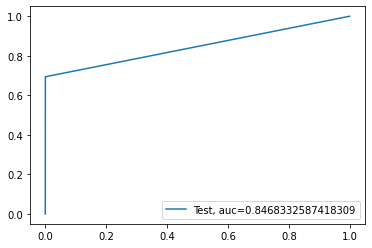

Time Taken by Model: --- 24.41987657546997 seconds ---
------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.999490879724724
Confusion Matrix


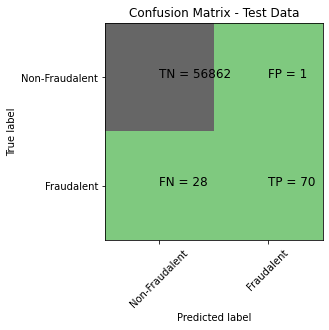

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.71      0.83        98

    accuracy                           1.00     56961
   macro avg       0.99      0.86      0.91     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.951101860648239
Random Forest threshold: 0.01
ROC for the test dataset 95.1%


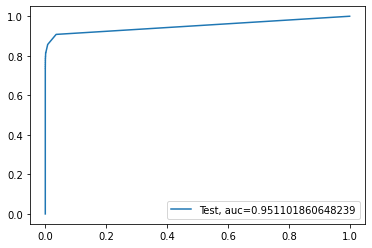

Time Taken by Model: --- 172.4803009033203 seconds ---
------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9962957111005776
Confusion Matrix


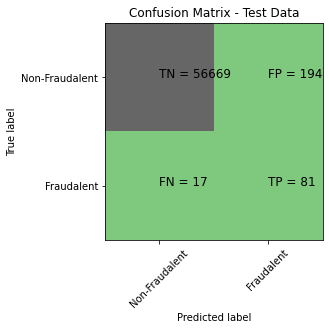

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.29      0.83      0.43        98

    accuracy                           1.00     56961
   macro avg       0.65      0.91      0.72     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9820801841303498
XGBoost threshold: 0.21093320846557617
ROC for the test dataset 98.2%


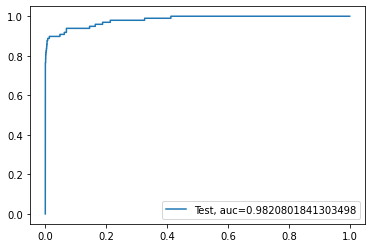

Time Taken by Model: --- 70.41744613647461 seconds ---
------------------------------------------------------------


In [43]:
Data_Imbalance_Handiling	 = "Random Oversampling with StratifiedKFold CV "
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results , Data_Imbalance_Handiling , X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

#Run KNN Model
print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results , Data_Imbalance_Handiling,X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results , Data_Imbalance_Handiling,X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results , Data_Imbalance_Handiling,X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

#Run XGBoost Model
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results , Data_Imbalance_Handiling,X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

In [44]:
# Checking the df_result dataframe which contains consolidated results of all the runs
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998964,0.969011,0.001423
1,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998929,0.869289,0.047230
2,RepeatedKFold Cross Validation,KNN,0.999263,0.864827,0.200000
3,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999245,0.874842,1.000000
4,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999087,0.874763,1.000000
5,RepeatedKFold Cross Validation,Random Forest,0.999491,0.932816,0.010000
6,RepeatedKFold Cross Validation,XGBoost,0.999438,0.970107,0.001447
7,RepeatedKFold Cross Validation,SVM,0.998086,0.421606,0.002741
8,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998771,0.983329,0.001572
9,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998754,0.889076,0.021087


### Results for Random Oversampling with StratifiedKFold technique:
Looking at the Accuracy and ROC value we have XGBoost which has provided best results for Random Oversampling and StratifiedKFold technique

## <a name="p4-4">Oversampling with SMOTE Oversampling</a>
- We will use SMOTE Oversampling method to handle the class imbalance

In [46]:
# Creating dataframe with Smote and StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from imblearn import over_sampling

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  
    SMOTE = over_sampling.SMOTE(random_state=0)
    X_train_Smote, y_train_Smote= SMOTE.fit_resample(X_train, y_train)
  
X_train_Smote = pd.DataFrame(data=X_train_Smote,   columns=cols)

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l1: 0.5
Max auc_roc for l2: 0.9930150238550091
Parameters for l1 regularisations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5

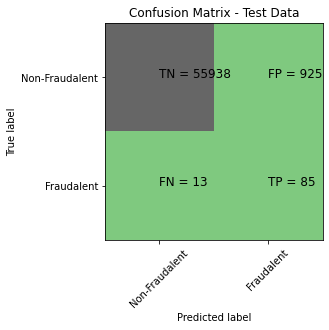

classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.08      0.87      0.15        98

    accuracy                           0.98     56961
   macro avg       0.54      0.93      0.57     56961
weighted avg       1.00      0.98      0.99     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


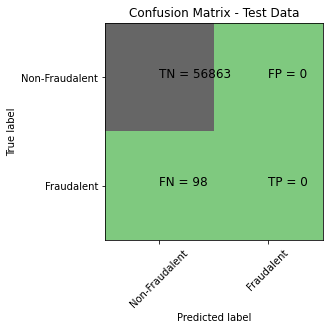

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9745821230906938
l2 threshold: 0.3940771805735311
ROC for the test dataset 97.5%


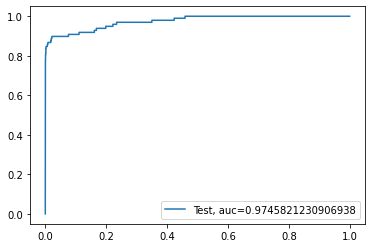

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


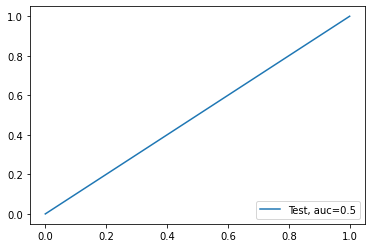

Time Taken by Model: --- 567.4116318225861 seconds ---
--------------------------------------------------------------------------------
KNN Model
model score
0.9946805709169432
Confusion Matrix


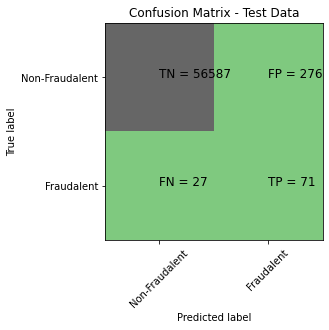

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.20      0.72      0.32        98

    accuracy                           0.99     56961
   macro avg       0.60      0.86      0.66     56961
weighted avg       1.00      0.99      1.00     56961

KNN roc_value: 0.8602674455287628
KNN threshold: 0.6
ROC for the test dataset 86.0%


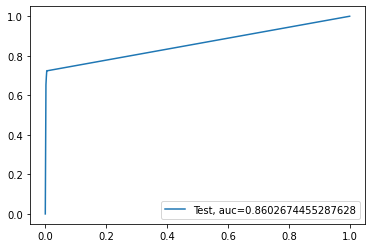

Time Taken by Model: --- 3060.9006798267365 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9977528484401608
Confusion Matrix


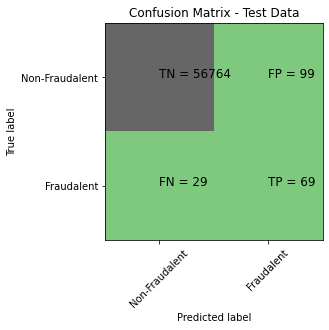

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.41      0.70      0.52        98

    accuracy                           1.00     56961
   macro avg       0.71      0.85      0.76     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8511703029874526
Tree threshold: 1.0
ROC for the test dataset 85.1%


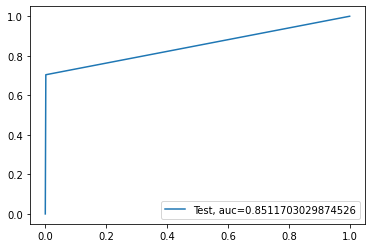

entropy score: 0.9969803900914661
Confusion Matrix


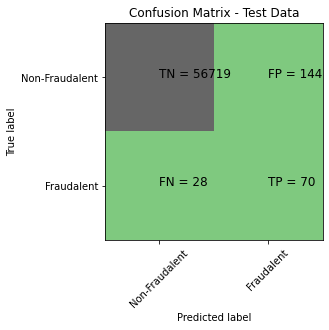

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.33      0.71      0.45        98

    accuracy                           1.00     56961
   macro avg       0.66      0.86      0.72     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8558766559223799
Tree threshold: 1.0
ROC for the test dataset 85.6%


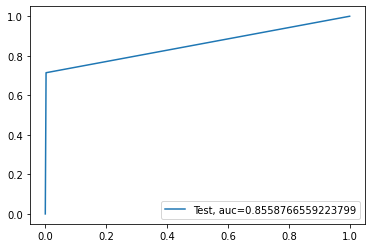

Time Taken by Model: --- 82.8795850276947 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.999490879724724
Confusion Matrix


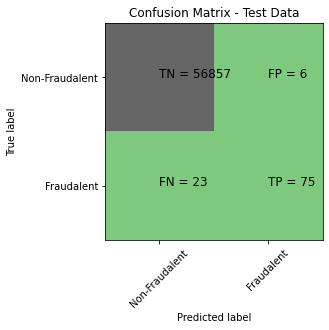

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.77      0.84        98

    accuracy                           1.00     56961
   macro avg       0.96      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9614705879186172
Random Forest threshold: 0.05
ROC for the test dataset 96.1%


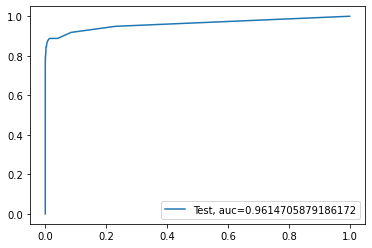

Time Taken by Model: --- 383.57139778137207 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9934165481645336
Confusion Matrix


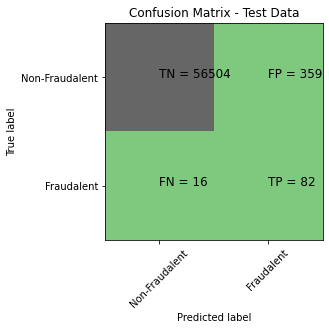

classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.19      0.84      0.30        98

    accuracy                           0.99     56961
   macro avg       0.59      0.92      0.65     56961
weighted avg       1.00      0.99      1.00     56961

XGboost roc_value: 0.9763188429619778
XGBoost threshold: 0.27664539217948914
ROC for the test dataset 97.6%


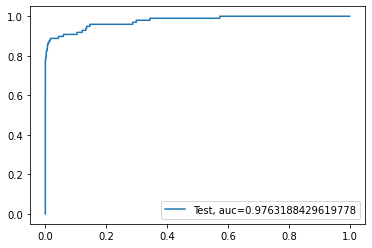

Time Taken by Model: --- 117.78114032745361 seconds ---
--------------------------------------------------------------------------------


In [47]:
Data_Imbalance_Handiling	 = "SMOTE Oversampling with StratifiedKFold CV "
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

#Run KNN Model
print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

#Run XGBoost Model
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

In [48]:
# Checking the df_result dataframe which contains consolidated results of all the runs
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998964,0.969011,0.001423
1,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998929,0.869289,0.047230
2,RepeatedKFold Cross Validation,KNN,0.999263,0.864827,0.200000
3,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999245,0.874842,1.000000
4,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999087,0.874763,1.000000
5,RepeatedKFold Cross Validation,Random Forest,0.999491,0.932816,0.010000
6,RepeatedKFold Cross Validation,XGBoost,0.999438,0.970107,0.001447
7,RepeatedKFold Cross Validation,SVM,0.998086,0.421606,0.002741
8,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998771,0.983329,0.001572
9,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998754,0.889076,0.021087


### Results for SMOTE Oversampling with StratifiedKFold:
Looking at Accuracy and ROC value we have XGBoost which has provided best results for SMOTE Oversampling with StratifiedKFold technique 

## <a name="p4-5">Oversampling with ADASYN Oversampling</a>
- We will use ADASYN Oversampling method to handle the class imbalance

In [53]:
# Creating dataframe with ADASYN and StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from imblearn import over_sampling

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  
    ADASYN = over_sampling.ADASYN(random_state=0)
    X_train_ADASYN, y_train_ADASYN= ADASYN.fit_resample(X_train, y_train)
  
X_train_ADASYN = pd.DataFrame(data=X_train_ADASYN,   columns=cols)

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l1: 0.5
Max auc_roc for l2: 0.9835151915234407
Parameters for l1 regularisations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5

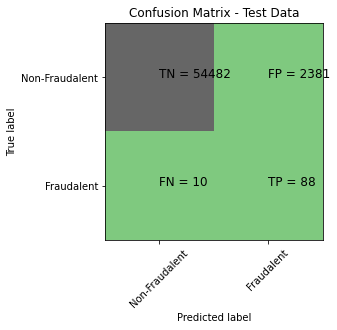

classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56863
           1       0.04      0.90      0.07        98

    accuracy                           0.96     56961
   macro avg       0.52      0.93      0.52     56961
weighted avg       1.00      0.96      0.98     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


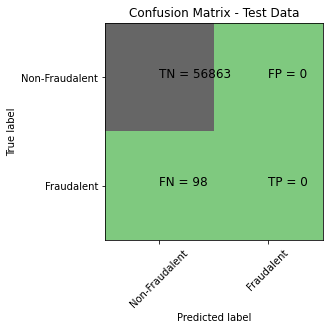

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9740234046241467
l2 threshold: 0.6115977022466358
ROC for the test dataset 97.4%


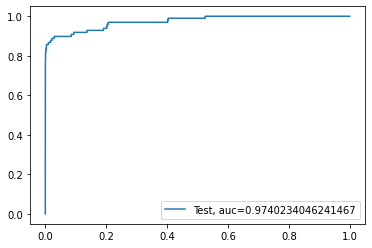

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


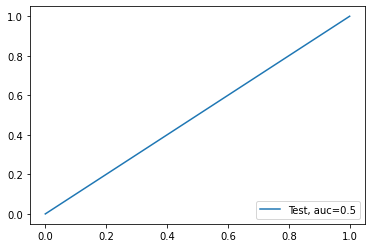

Time Taken by Model: --- 648.8162662982941 seconds ---
--------------------------------------------------------------------------------
KNN Model
model score
0.9945050122013307
Confusion Matrix


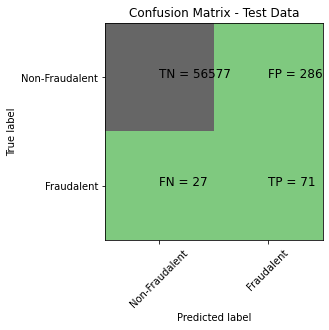

classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.20      0.72      0.31        98

    accuracy                           0.99     56961
   macro avg       0.60      0.86      0.65     56961
weighted avg       1.00      0.99      1.00     56961

KNN roc_value: 0.8601937811862167
KNN threshold: 0.6
ROC for the test dataset 86.0%


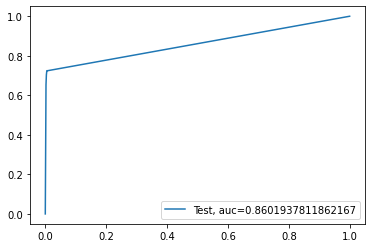

Time Taken by Model: --- 2780.0399057865143 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9979459630273345
Confusion Matrix


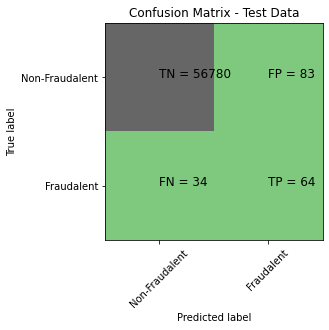

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.44      0.65      0.52        98

    accuracy                           1.00     56961
   macro avg       0.72      0.83      0.76     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8258007879303172
Tree threshold: 1.0
ROC for the test dataset 82.6%


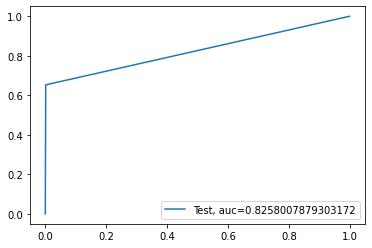

entropy score: 0.9954179175225154
Confusion Matrix


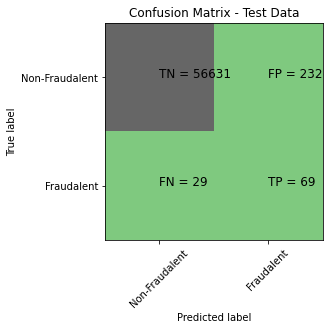

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.23      0.70      0.35        98

    accuracy                           1.00     56961
   macro avg       0.61      0.85      0.67     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8500008254713172
Tree threshold: 1.0
ROC for the test dataset 85.0%


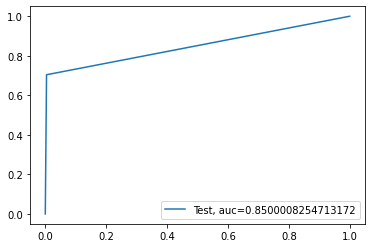

Time Taken by Model: --- 83.75130772590637 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9995259914678464
Confusion Matrix


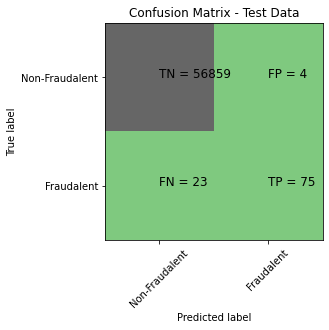

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56961
   macro avg       0.97      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9632269575962563
Random Forest threshold: 0.03
ROC for the test dataset 96.3%


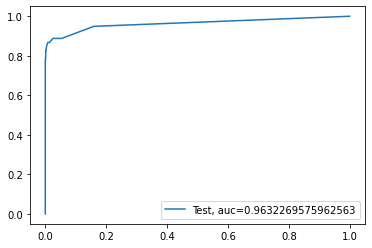

Time Taken by Model: --- 398.62654280662537 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9858675233931988
Confusion Matrix


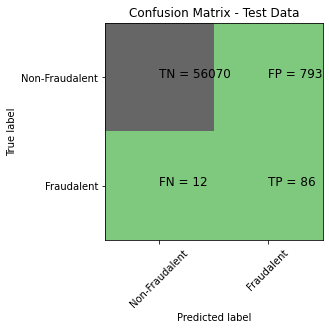

classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.10      0.88      0.18        98

    accuracy                           0.99     56961
   macro avg       0.55      0.93      0.58     56961
weighted avg       1.00      0.99      0.99     56961

XGboost roc_value: 0.9783021275267049
XGBoost threshold: 0.5225471258163452
ROC for the test dataset 97.8%


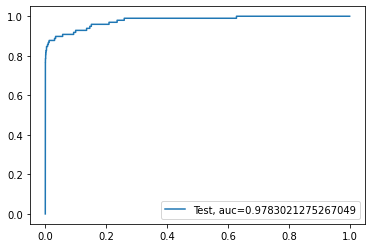

Time Taken by Model: --- 119.51173400878906 seconds ---
--------------------------------------------------------------------------------


In [54]:
Data_Imbalance_Handiling	 = "ADASYN Oversampling with StratifiedKFold CV "
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results, Data_Imbalance_Handiling, X_train_ADASYN, y_train_ADASYN , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

#Run KNN Model
print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results, Data_Imbalance_Handiling,X_train_ADASYN, y_train_ADASYN , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results, Data_Imbalance_Handiling,X_train_ADASYN, y_train_ADASYN , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results, Data_Imbalance_Handiling,X_train_ADASYN, y_train_ADASYN , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

#Run XGBoost Model
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results, Data_Imbalance_Handiling,X_train_ADASYN, y_train_ADASYN , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

In [55]:
# Checking the df_result dataframe which contains consolidated results of all the runs
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998964,0.969011,0.001423
1,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998929,0.869289,0.047230
2,RepeatedKFold Cross Validation,KNN,0.999263,0.864827,0.200000
3,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999245,0.874842,1.000000
4,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999087,0.874763,1.000000
5,RepeatedKFold Cross Validation,Random Forest,0.999491,0.932816,0.010000
6,RepeatedKFold Cross Validation,XGBoost,0.999438,0.970107,0.001447
7,RepeatedKFold Cross Validation,SVM,0.998086,0.421606,0.002741
8,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998771,0.983329,0.001572
9,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998754,0.889076,0.021087


## Results for ADASYN  Oversampling with StratifiedKFold: 
Looking at Accuracy and ROC value we have XGBoost which has provided best results for ADASYN Oversampling with StratifiedKFold technique 

## Overall conclusion after running the models on Oversampled data :
Looking at above results it seems XGBOOST model with Random Oversampling with StratifiedKFold CV has provided the best results under the category of all oversampling techniques. So we will try to tune the hyperparameters of this model to get best results.

## <a name="p5">Hyperparameter Tuning</a>

## HPT - Xgboost Regression

In [57]:
# Performing Hyperparameter tuning
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
param_test = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'n_estimators':range(60,130,150),
 'learning_rate':[0.05,0.1,0.125,0.15,0.2],
 'gamma':[i/10.0 for i in range(0,5)],
 'subsample':[i/10.0 for i in range(7,10)],
 'colsample_bytree':[i/10.0 for i in range(7,10)]
}

gsearch1 = RandomizedSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1,max_delta_step=0,
              missing=None, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, verbosity=1), 
              param_distributions = param_test, n_iter=5,scoring='roc_auc',n_jobs=-1, cv=5)

gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 78.0790154 ,  89.69091663, 113.30138698,  41.1210391 ,
         124.47327914]),
  'mean_score_time': array([0.33167305, 0.39689088, 0.43635864, 0.25277925, 0.39153495]),
  'mean_test_score': array([0.99737639, 0.9998794 , 0.99985979, 0.99902151, 0.99986951]),
  'param_colsample_bytree': masked_array(data=[0.9, 0.7, 0.7, 0.7, 0.9],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_gamma': masked_array(data=[0.2, 0.2, 0.0, 0.4, 0.0],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_learning_rate': masked_array(data=[0.15, 0.125, 0.1, 0.2, 0.125],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_max_depth': masked_array(data=[5, 7, 9, 3, 9],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  '

Please note that the hyperparameters found above using RandomizedSearchCV and the hyperparameters used below in creating the final model might be different, the reason being, I have executed the RandomizedSearchCV multiple times to find which set of hyperparameters gives the optimum result and finally used the one below which gave me the best performance.

In [59]:
# Creating XGBoost model with selected hyperparameters
from xgboost import XGBClassifier

clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2,
              learning_rate=0.125, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=60, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

# fit on the dataset
clf.fit(X_over, y_over ) 
XGB_test_score = clf.score(X_test, y_test)
print('Model Accuracy: {0}'.format(XGB_test_score))

# Probabilities for each class
XGB_probs = clf.predict_proba(X_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

Model Accuracy: 0.9993328768806727
XGboost roc_value: 0.9815403079438694
XGBoost threshold: 0.01721232570707798


### Print the important features of the best model to understand the dataset

In [60]:
imp_var = []
for i in clf.feature_importances_:
    imp_var.append(i)
print('Top var =', imp_var.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', imp_var.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', imp_var.index(np.sort(clf.feature_importances_)[-3])+1)

Top var = 14
2nd Top var = 17
3rd Top var = 10


In [61]:
# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

XGboost roc_value: 0.9815403079438694
XGBoost threshold: 0.01721232570707798


## <a name="p6">Conclusion</a>

In the oversample cases, of all the models we build found that the XGBOOST model with Random Oversampling with StratifiedKFold CV gave us the best accuracy and ROC on oversampled data. Post that we performed hyperparameter tuning and got the below metrices : 

XGboost roc_value: 0.9815403079438694
XGBoost threshold: 0.01721232570707798

However, of all the models we created we found Logistic Regression with L2 Regularisation for StratifiedKFold cross validation (without any oversampling or undersampling) gave us the best result.